In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [2]:
def printdf(df, round=2):
    with io.StringIO() as buffer:
        df.round(round).to_csv(buffer, sep=' ', index=False)
        print(buffer.getvalue())

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/reports/seqkit/raw.fastq.report.txt"

pdf = pd.read_csv(fpath, sep=r"\s+")
pdf['sample'] = pdf['file'].apply(lambda x: x.split("b")[0])
pdf['cell'] = pdf['file'].apply(lambda x: x[2:5])

columns = [
    'num_seqs',
    'sum_len',
    'min_len',
    'avg_len',
    'max_len',
    'N50',
] 

for c in columns:
    pdf[c] = pdf[c].astype(str).str.replace(',', '').astype(float)

pdf.head()

,file,format,type,num_seqs,sum_len,min_len,avg_len,max_len,Q1,Q2,Q3,sum_gap,N50,Q20(%),Q30(%),AvgQual,GC(%),sample,cell
0,o1b01.raw.fastq,FASTQ,DNA,2167.0,1611820.0,143.0,743.8,6463.0,390,601,927,0,900.0,71.67,58.20,14.67,43.88,o1,b01
1,o1b02.raw.fastq,FASTQ,DNA,175455.0,230059803.0,39.0,1311.2,10324.0,864,"1,332","1,646",0,1540.0,36.12,11.65,14.15,42.69,o1,b02
2,o1b03.raw.fastq,FASTQ,DNA,275086.0,352365516.0,38.0,1280.9,9801.0,813,"1,257","1,608",0,1442.0,26.68,5.04,13.89,43.17,o1,b03
3,o1b04.raw.fastq,FASTQ,DNA,292912.0,398683904.0,38.0,1361.1,109418.0,942,"1,295","1,611",0,1502.0,34.24,10.05,14.00,42.75,o1,b04
4,o1b05.raw.fastq,FASTQ,DNA,431367.0,580758138.0,35.0,1346.3,11049.0,945,"1,313","1,658",0,1552.0,30.54,7.01,14.11,42.53,o1,b05


In [4]:
dpath = "/scratch/indikar_root/indikar1/cstansbu/scpc_test/barcode_locations/"

df = []

for f in os.listdir(dpath):
    fpath = f"{dpath}{f}"
    tmp = pd.read_csv(fpath, sep='\t')
    tmp['n_matches'] = tmp.groupby('seqID')['patternName'].transform('count')
    tmp['match_cat'] = np.where(tmp['n_matches'] == 1, 'One', 'Many')
    tmp['match_cat'] = np.where(tmp['n_matches'] == 2, 'Two', tmp['match_cat'])
    tmp['sample'] = f.replace(".csv", "")[0:2]
    tmp['cell'] = f.replace(".csv", "")[2:]
    df.append(tmp)

df = pd.concat(df)
print(f"{df.shape=}")
df.head()

df.shape=(228821739, 11)


,seqID,patternName,pattern,strand,start,end,matched,n_matches,match_cat,sample,cell
0,421367d1-eb63-4659-bbca-58035c7def4e,b93,AGTTTCCATCACTTCAGACTTGGG,+,50,73,AGTTTCCATCACTTCAGACTTGGG,2,Two,o3,b93
1,421367d1-eb63-4659-bbca-58035c7def4e,b93,AGTTTCCATCACTTCAGACTTGGG,-,1508,1531,AGTTTCCATCACTTCAGACTTGGG,2,Two,o3,b93
2,92f777b5-5a02-4eef-97ac-56969ef57c8e,b95,CCTGTCTGGAAGAAGAATGGACTT,+,108,131,CCTGTCTGGAAGAAGAATGGACTT,6,Many,o3,b93
3,92f777b5-5a02-4eef-97ac-56969ef57c8e,b95,CCTGTCTGGAAGAAGAATGGACTT,+,226,249,CCTGTCTGGAAGAAGAATGGACTT,6,Many,o3,b93
4,92f777b5-5a02-4eef-97ac-56969ef57c8e,b95,CCTGTCTGGAAGAAGAATGGACTT,+,338,361,CCTGTCTGGAAGAAGAATGGACTT,6,Many,o3,b93


In [5]:
gx = df.groupby(['sample', 'cell', 'match_cat'])['seqID'].nunique()
gx = gx.reset_index(drop=False)
gx.head()

,sample,cell,match_cat,seqID
0,o1,b01,Many,1679
1,o1,b01,One,149
2,o1,b01,Two,242
3,o1,b02,Many,4052
4,o1,b02,One,63313


In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [15]:
gdf = pd.pivot_table(gx, 
                     index=['sample', 'cell'], 
                     columns='match_cat', 
                     values='seqID')

gdf['with_barcode'] = gdf.sum(axis=1)
cols = ['One', 'Two', 'Many']

for c in cols:
    gdf[f"{c}_per"] = gdf[c] / gdf['with_barcode']

gdf = gdf.reset_index(drop=False)


gdf = pd.merge(gdf, pdf[['sample', 'cell', 'num_seqs']], 
               how='left',
               left_on=['sample', 'cell'],
               right_on=['sample', 'cell'])

gdf.head()
gdf['without_barcode'] = gdf['num_seqs'] - gdf['with_barcode']
printdf(gdf)

sample cell Many One Two with_barcode One_per Two_per Many_per num_seqs without_barcode
o1 b01 1679 149 242 2070 0.07 0.12 0.81 2167.0 97.0
o1 b02 4052 63313 95302 162667 0.39 0.59 0.02 175455.0 12788.0
o1 b03 4869 110268 135830 250967 0.44 0.54 0.02 275086.0 24119.0
o1 b04 55589 97641 110579 263809 0.37 0.42 0.21 292912.0 29103.0
o1 b05 6588 128518 278298 413404 0.31 0.67 0.02 431367.0 17963.0
o1 b06 4838 201244 191838 397920 0.51 0.48 0.01 448352.0 50432.0
o1 b07 77410 15181 30578 123169 0.12 0.25 0.63 126291.0 3122.0
o1 b08 4392 119009 132755 256156 0.46 0.52 0.02 289062.0 32906.0
o1 b09 4438 103098 169071 276607 0.37 0.61 0.02 292534.0 15927.0
o1 b10 6557 167248 271925 445730 0.38 0.61 0.01 472172.0 26442.0
o1 b11 77651 3634 6717 88002 0.04 0.08 0.88 88995.0 993.0
o1 b12 15872 16005 20215 52092 0.31 0.39 0.3 56547.0 4455.0
o1 b13 2098 45068 57107 104273 0.43 0.55 0.02 115529.0 11256.0
o1 b14 763 20329 14495 35587 0.57 0.41 0.02 42470.0 6883.0
o1 b15 52526 1672 3251 57449 0.03 0.06 

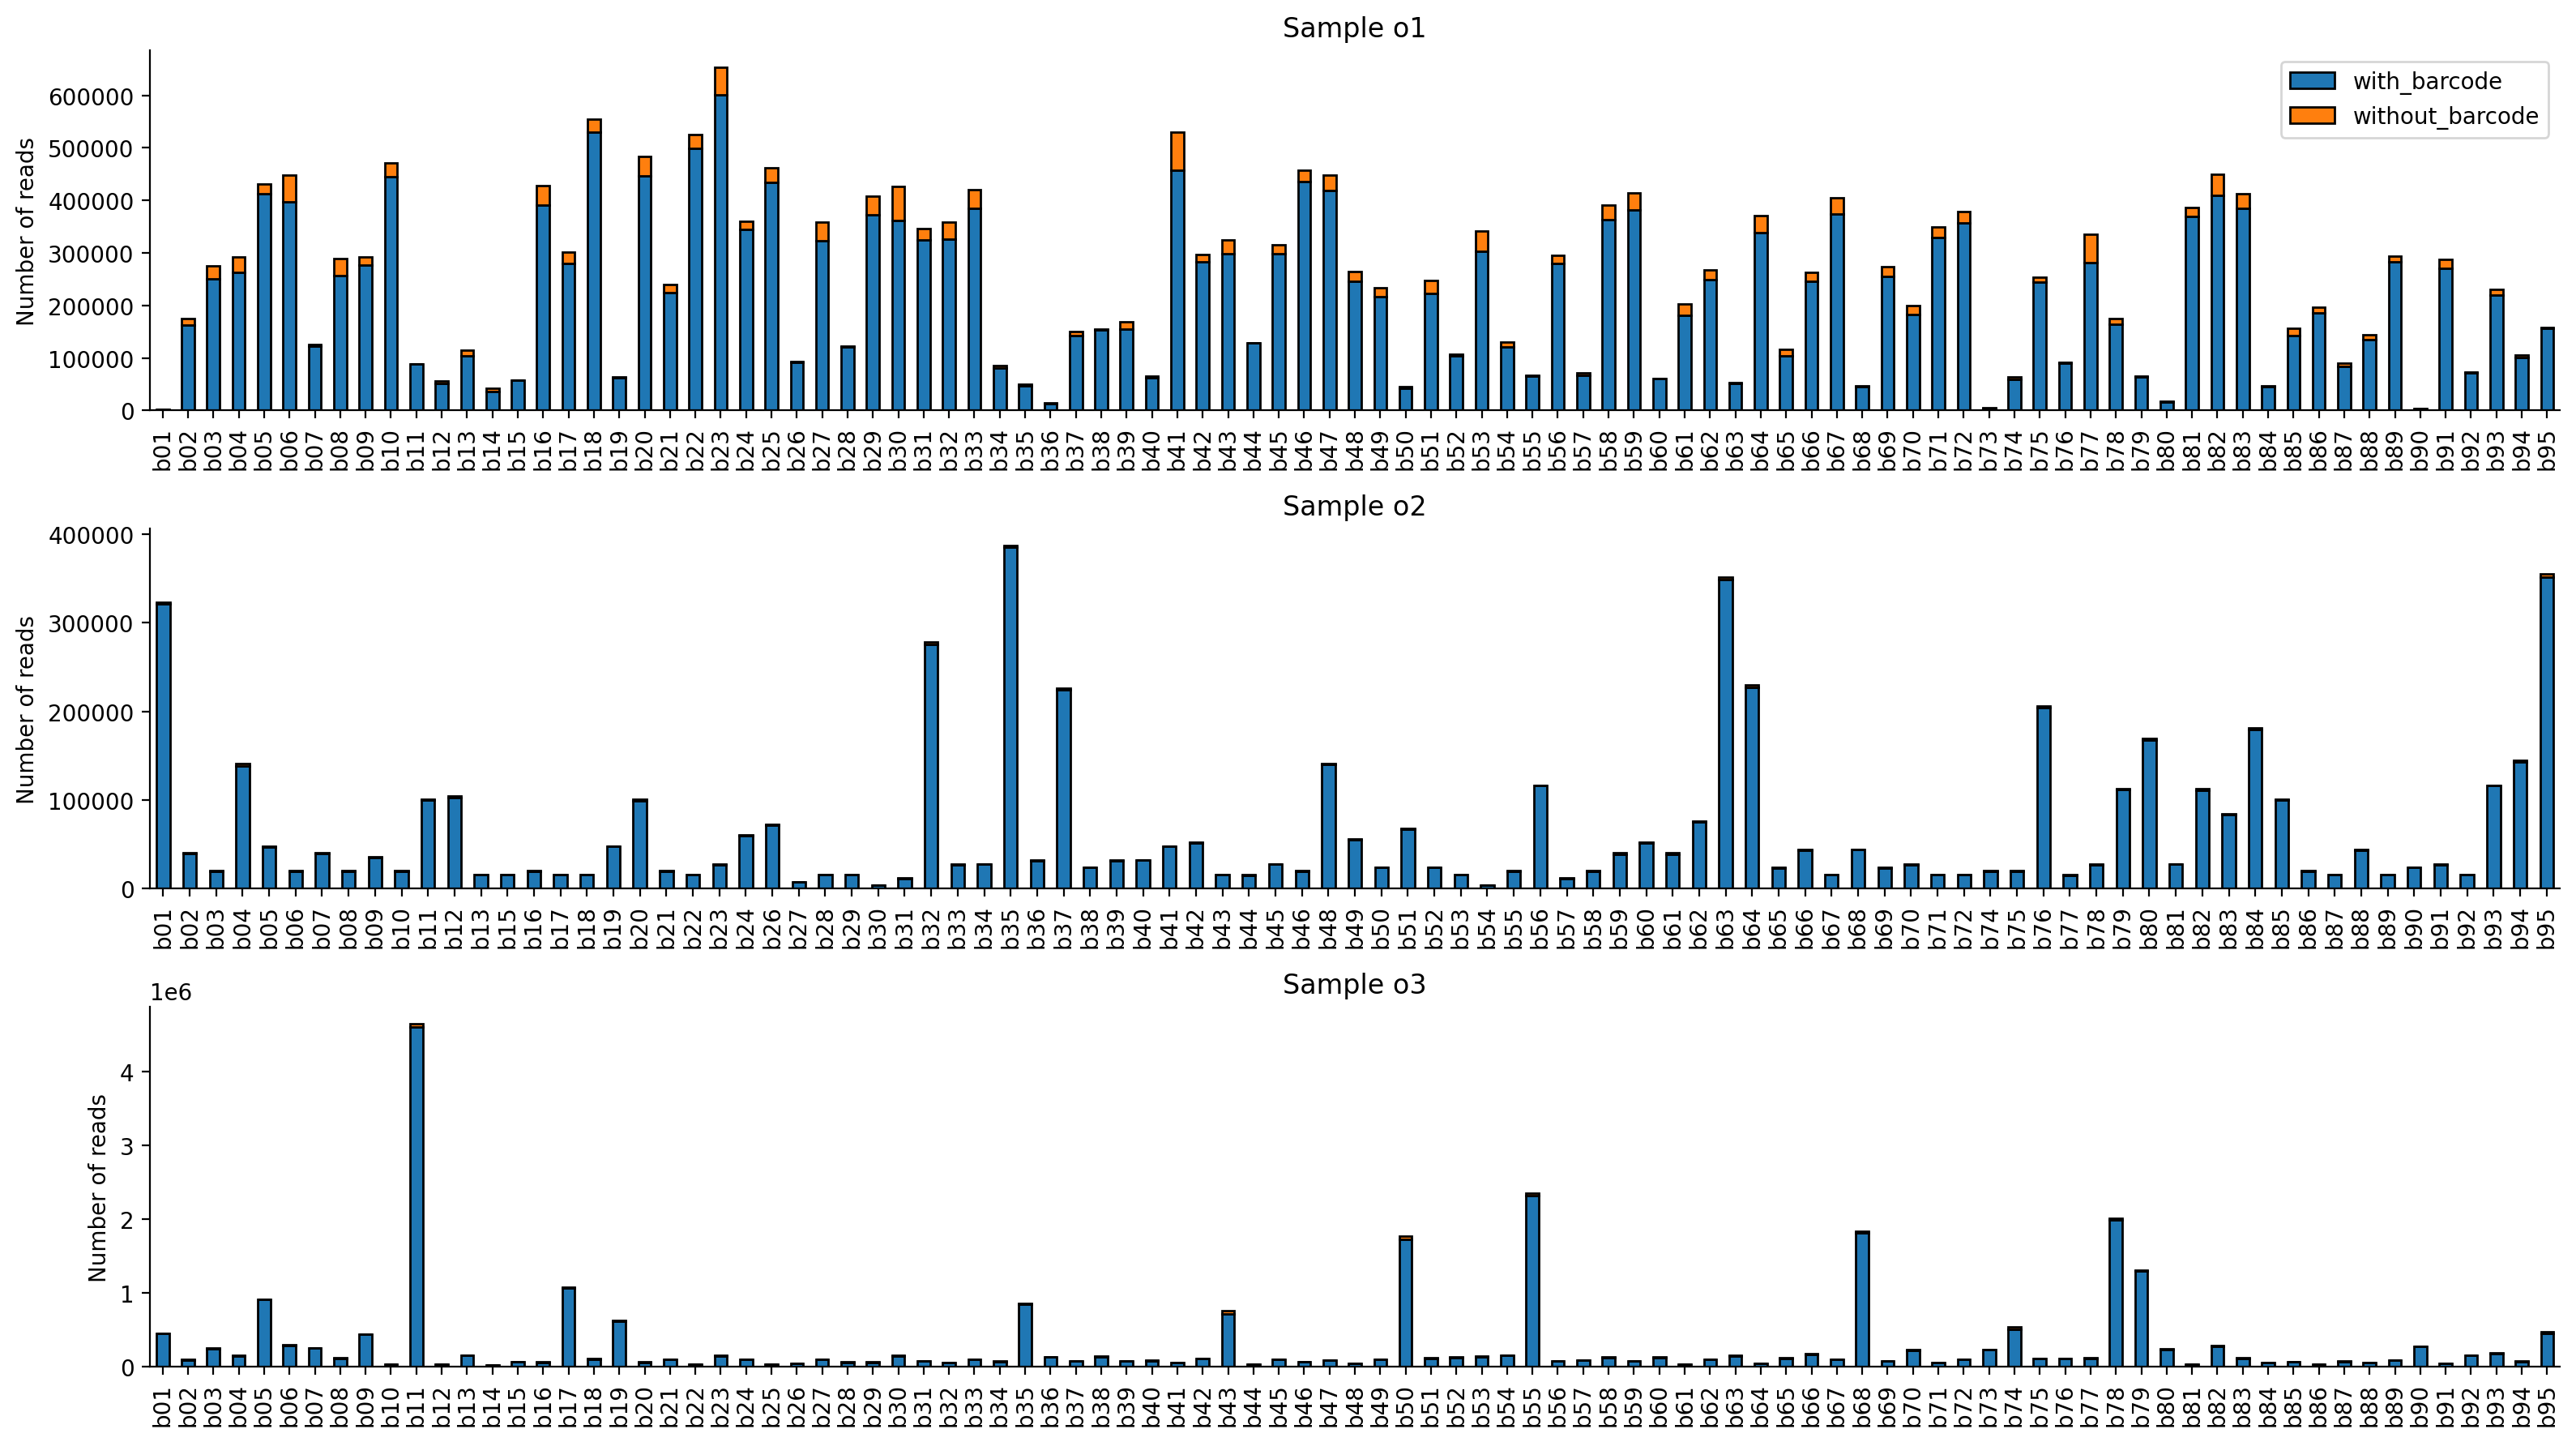

In [22]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 16, 9

fig, axs = plt.subplots(3, 1)


for i, (sample, group) in enumerate(gdf.groupby('sample')):
    group = group[['cell', 'with_barcode', 'without_barcode']]
    group = group.set_index('cell')
    group.plot(kind='bar', stacked=True, ec='k', ax=axs[i])
    axs[i].set_title(f'Sample {sample}')
    axs[i].set_ylabel('Number of reads')
    axs[i].set_xlabel('')
    if i != 0:
        axs[i].legend().remove()

plt.tight_layout()
sns.despine()

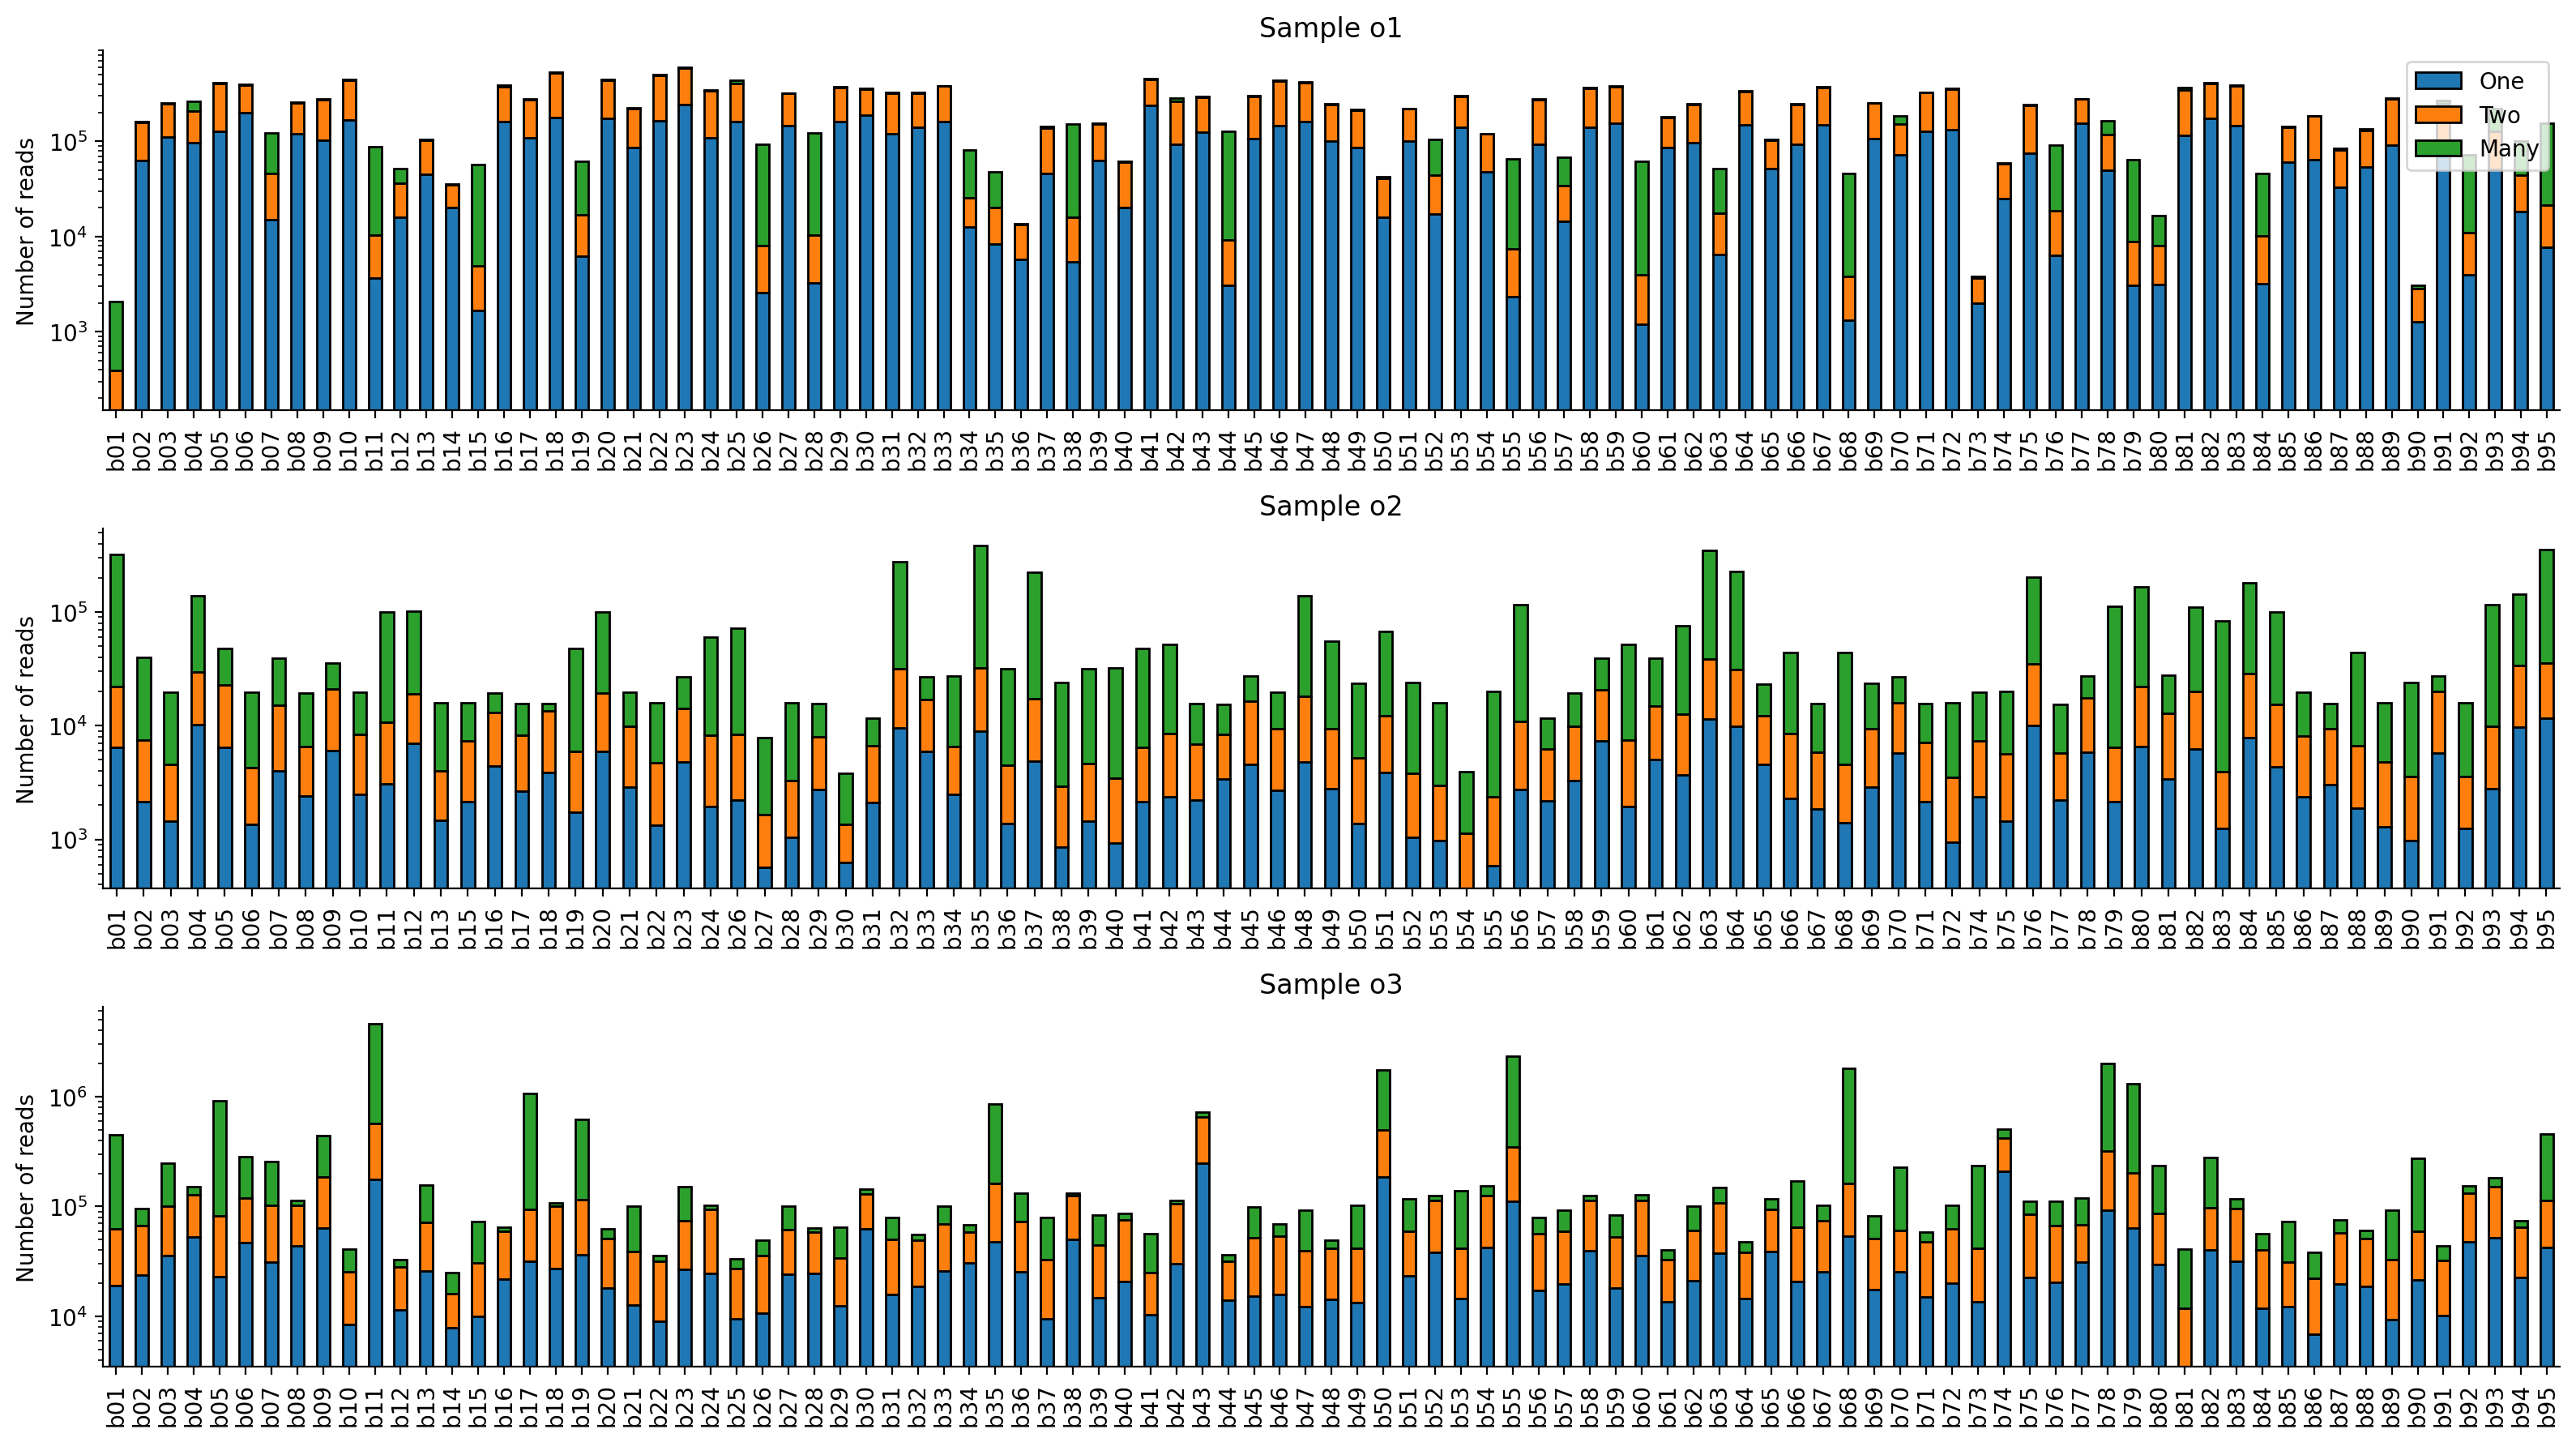

In [26]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 16, 9

fig, axs = plt.subplots(3, 1)

for i, (sample, group) in enumerate(gdf.groupby('sample')):
    group = group[['cell', 'One', 'Two', 'Many']]
    group = group.set_index('cell')
    group.plot(kind='bar', stacked=True, ec='k', ax=axs[i])
    axs[i].set_title(f'Sample {sample}')
    axs[i].set_ylabel('Number of reads')
    axs[i].set_xlabel('')
    axs[i].set_yscale('log')
    if i != 0:
        axs[i].legend().remove()
    else:
        sns.move_legend(axs[i],
                        loc='upper right')

plt.tight_layout()
sns.despine()

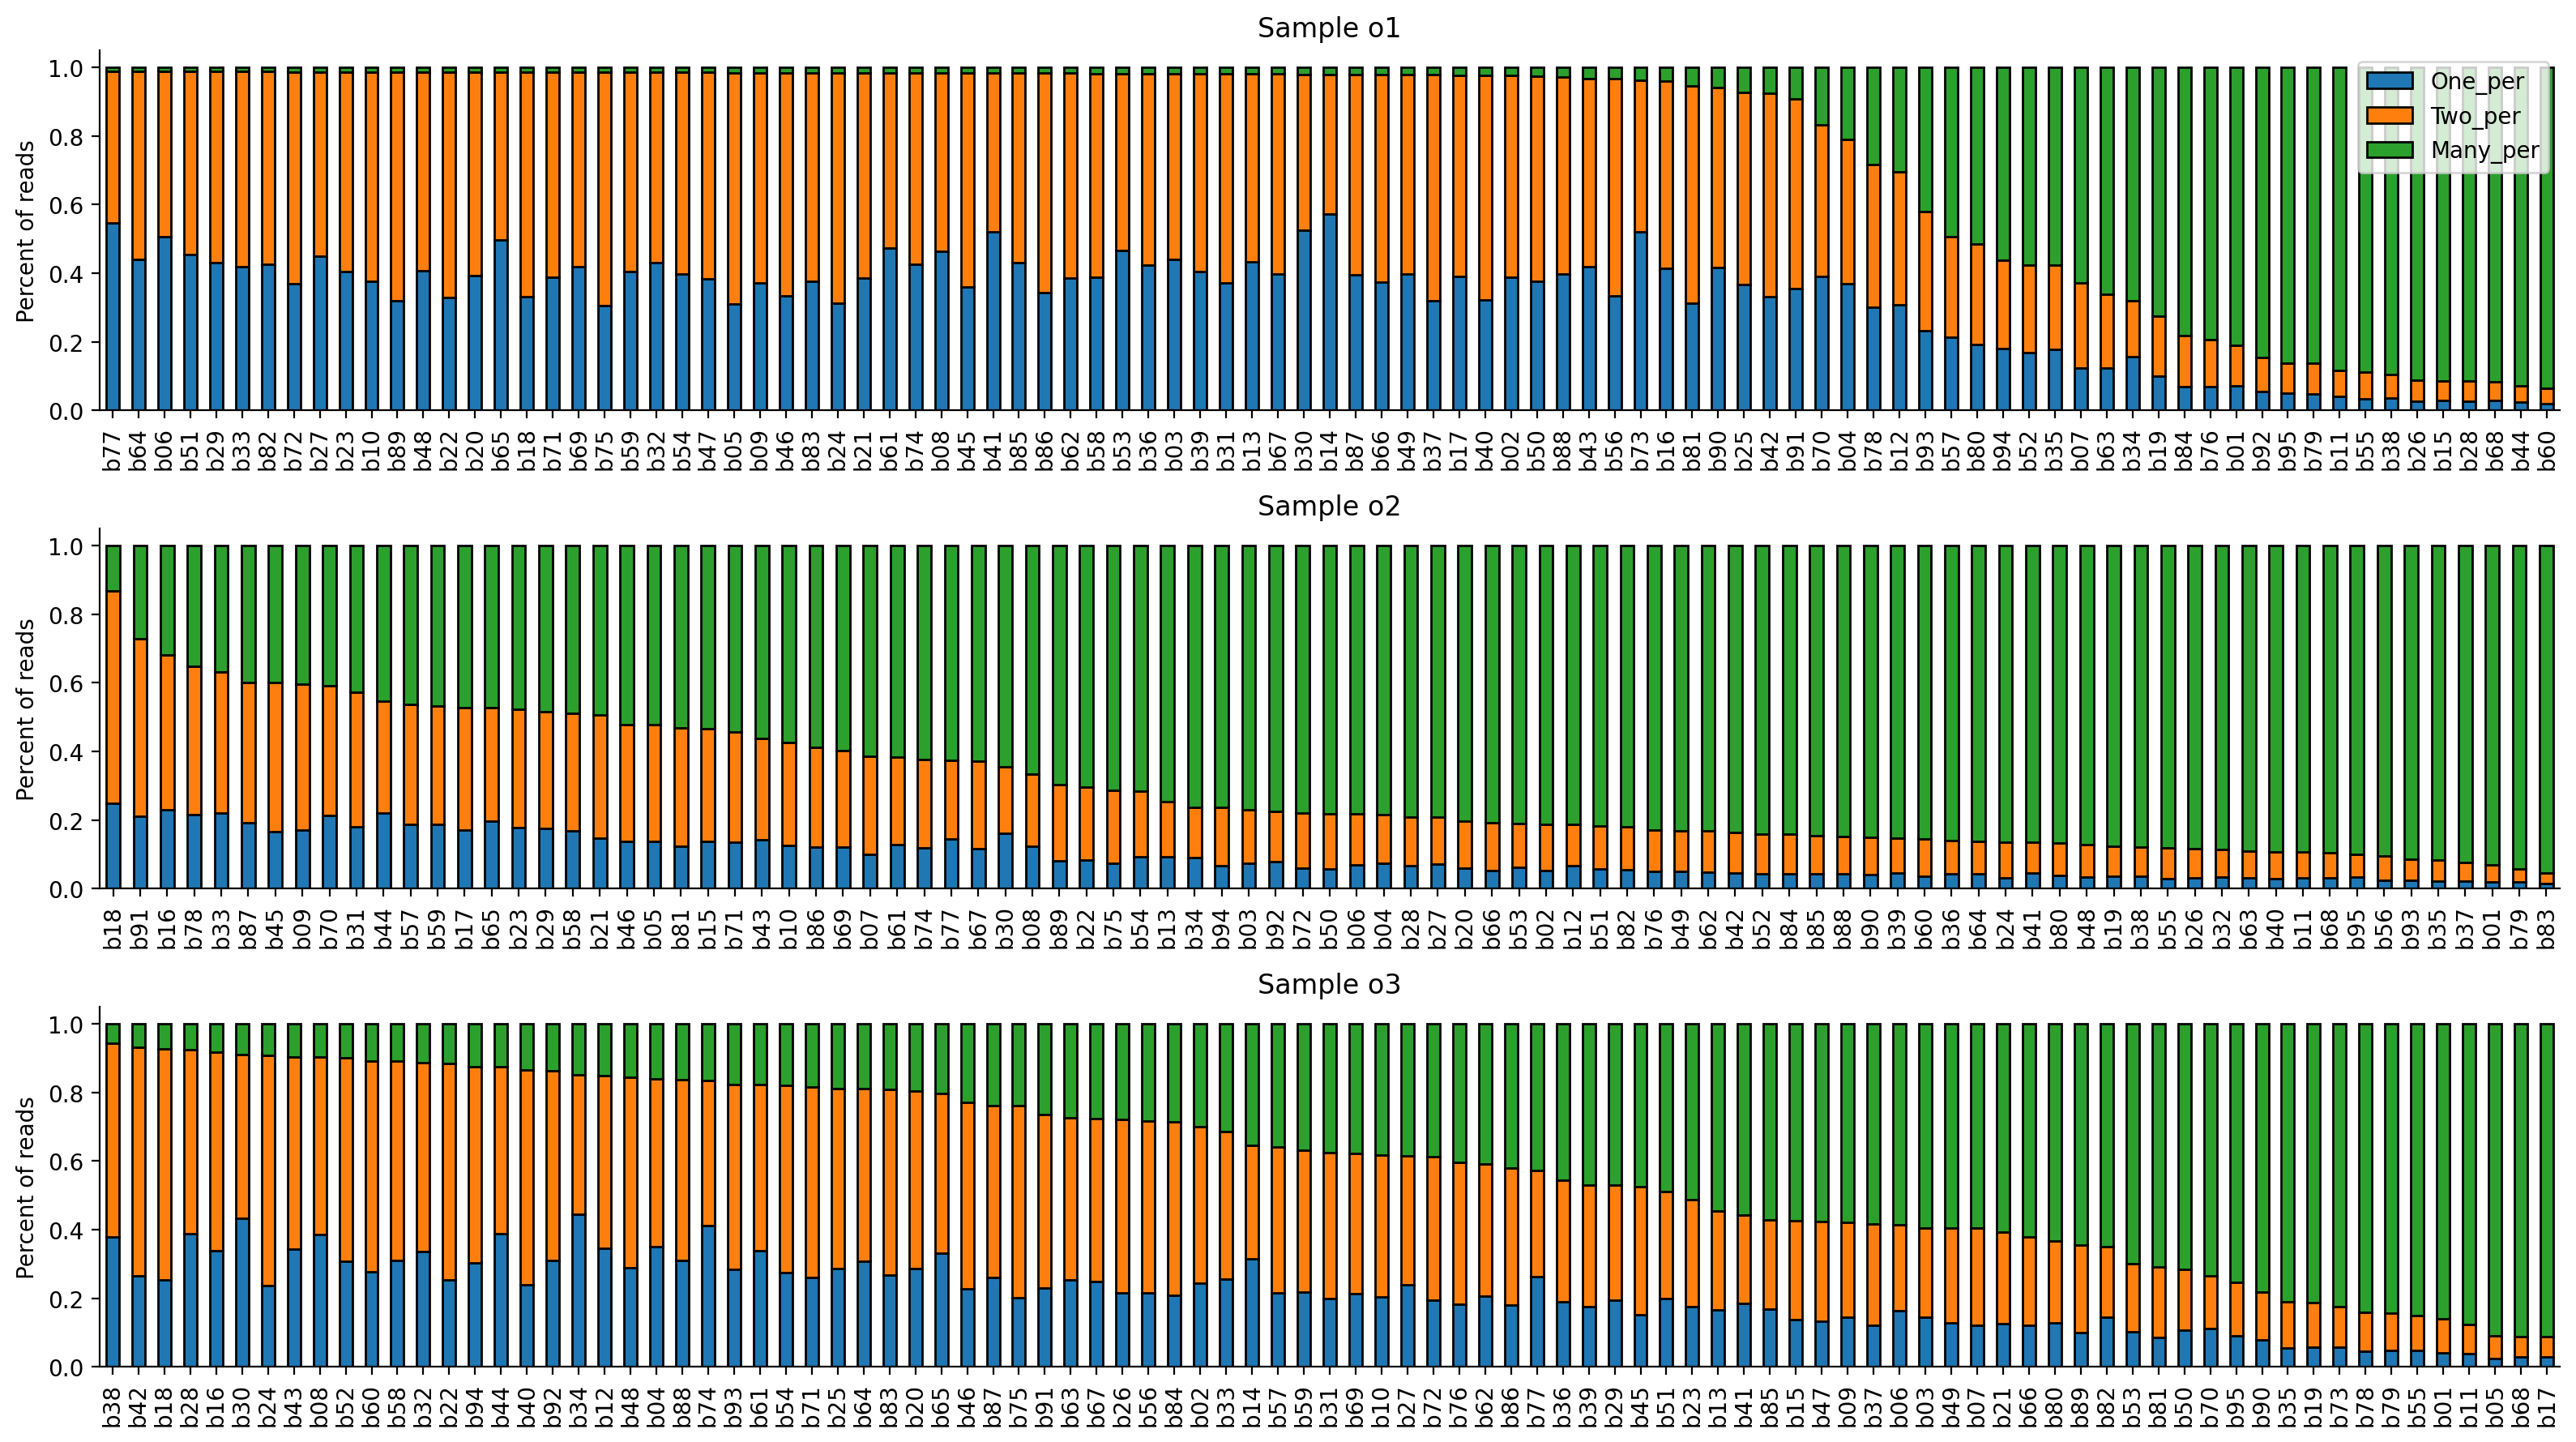

In [28]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 16, 9

fig, axs = plt.subplots(3, 1)

for i, (sample, group) in enumerate(gdf.groupby('sample')):
    group = group[['cell', 'One_per', 'Two_per', 'Many_per']]
    group = group.sort_values(by='Many_per')
    group = group.set_index('cell')
    group.plot(kind='bar', stacked=True, ec='k', ax=axs[i])
    axs[i].set_title(f'Sample {sample}')
    axs[i].set_ylabel('Percent of reads')
    axs[i].set_xlabel('')
    if i != 0:
        axs[i].legend().remove()
    else:
        sns.move_legend(axs[i],
                        loc='upper right')

plt.tight_layout()
sns.despine()